# Introduction

Hello, I'm **Wesley**, nice to meet you!👋 

I was just reading the IMDb reviews of [*The Super Mario Bros. Movie*](https://www.imdb.com/title/tt6718170/), I thought why don't we make a **Sentiment Classifier** to categorize movie reviews! **WARNING: Spoilers ahead.**

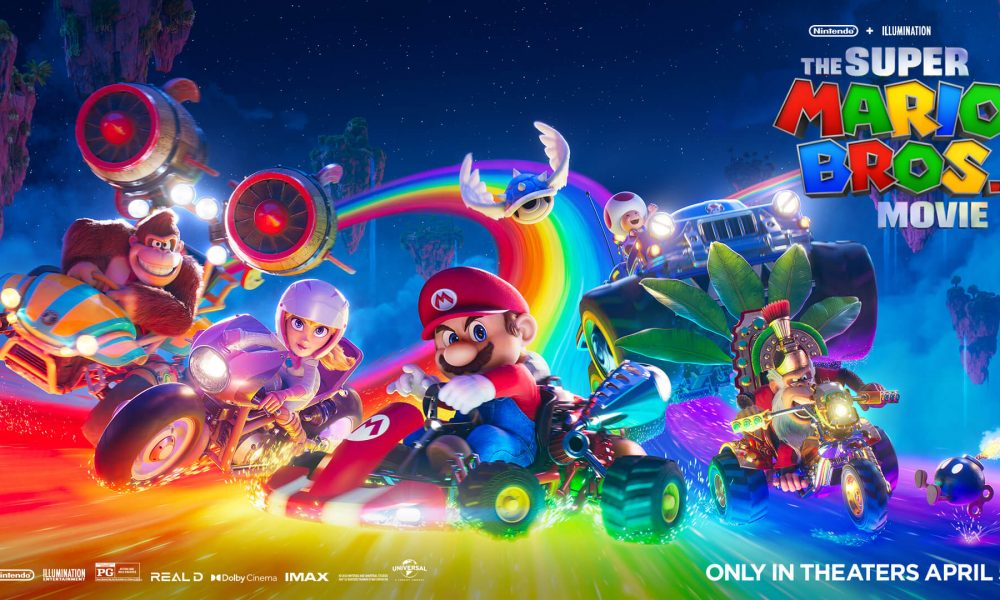

Here we will be doing [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) on BERT [(blog)](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html) [(paper)](https://arxiv.org/abs/1810.04805v2) with an IMDb dataset to make a sentiment classifier for movie reviews.

# Setup Python Libraries (pip)

In [1]:
# install some Python packages with pip

!pip install numpy torch datasets transformers evaluate --quiet

In [2]:
# let's check the version we are using

!pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate'

datasets==2.1.0
evaluate==0.4.0
numpy==1.21.6
torch @ file:///tmp/torch/torch-1.11.0-cp37-cp37m-linux_x86_64.whl
torchaudio @ file:///tmp/torch/torchaudio-0.11.0-cp37-cp37m-linux_x86_64.whl
torchmetrics==0.10.0
torchtext @ file:///tmp/torch/torchtext-0.12.0-cp37-cp37m-linux_x86_64.whl
torchvision @ file:///tmp/torch/torchvision-0.12.0-cp37-cp37m-linux_x86_64.whl
transformers==4.20.1


# Create IMDB Dataset for Fine-tuning BERT

## Let's load the IMDB Dataset

In [3]:
from datasets import load_dataset

# let's load the imdb dataset from huggingface
# source: (https://huggingface.co/datasets/imdb)

raw_dataset = load_dataset('imdb')
raw_dataset

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

## Let's create the train, validation, test sets

In [4]:
# get train and validation set

dataset = raw_dataset['train'].train_test_split(test_size=0.2, seed=42, shuffle=True)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})

In [5]:
# rename validation key to 'val'

dataset['val'] = dataset['test'] 
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})

In [6]:
# copy test set from raw_dataset

dataset['test'] = raw_dataset['test']
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})

## We start by tokenizing our dataset with the BERT's Fast Tokenizer

In [7]:
# let's import the pretrained faster tokenizer from huggingface
# source: (https://huggingface.co/distilbert-base-uncased)

from transformers import AutoTokenizer

checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)
tokenizer

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [8]:
# tokenize the text in batches with truncation and padding based on BERT requirements

def tokenization(example):
    return tokenizer(example['text'], truncation=True, padding=True)

tokenized_dataset = dataset.map(tokenization, batched=True, remove_columns=['text'])
tokenized_dataset

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 5000
    })
})

# Setup Training Metrics (Accuracy, F1)

In [9]:
import evaluate
import numpy as np

# we setup the training to evaluate the accuracy and f1 scores

accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)
    return {**accuracy, **f1}

# Setup Training Configurations

In [10]:
import os
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# get bert model with a sequence classification head for sentiment analysis
# source: (https://huggingface.co/distilbert-base-uncased)
checkpoint = 'distilbert-base-uncased'
num_labels = 2
id2label = {0:'NEGATIVE',1:'POSITIVE'}
label2id = {'NEGATIVE':0,'POSITIVE':1}
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id)

# setup custom training arguments
# 1. store training checkpoints to 'results' output directory
# 2. fine-tune for just 1 epoch
# 3,4. use 16 as a batch size to speed things up
# 5. evaluate validation set every 500 steps (this is the default steps)
# 6. load the best model based on the lowest validation loss at the end of training
training_args = TrainingArguments(
    seed=42,
    output_dir = './results',
    num_train_epochs = 1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy='steps',
    load_best_model_at_end=True,
)

# setup trainer with custom metrics (accuracy, f1)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    compute_metrics=compute_metrics,
)

# disable wandb logging (a v4 huggingface artifact)
os.environ['WANDB_DISABLED']= "true"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

# Evaluate UnFine-Tuned BERT on Test Set for a Baseline Metric


In [11]:
# let's first evaluate unfine-tuned model with test set

trainer.evaluate(tokenized_dataset['test'])

***** Running Evaluation *****
  Num examples = 25000
  Batch size = 16


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'eval_loss': 0.6902232766151428,
 'eval_accuracy': 0.5292,
 'eval_f1': 0.1909540830354688,
 'eval_runtime': 237.3319,
 'eval_samples_per_second': 105.338,
 'eval_steps_per_second': 6.586}

Without fine-tuning BERT, our model currently has around **52% Accuracy (eval_accuracy)** and **19% F1 (eval_f1)**, which is pretty bad due to the test dataset having around 50% positive and 50% negative reviews. 😕


Let's make it better with transfer learning! 🦾

# Fine-Tune BERT with IMDb Dataset

In [12]:
# let's fine-tune BERT with the IMDb dataset

trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 20000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1250


Step,Training Loss,Validation Loss,Accuracy,F1
500,0.326800,0.291335,0.887200,0.879641
1000,0.241900,0.220952,0.918600,0.918649


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-1000 (score: 0.22095181047916412).


TrainOutput(global_step=1250, training_loss=0.2728530853271484, metrics={'train_runtime': 652.2036, 'train_samples_per_second': 30.665, 'train_steps_per_second': 1.917, 'total_flos': 2649347973120000.0, 'train_loss': 0.2728530853271484, 'epoch': 1.0})

In [13]:
# let's see how well it did in the test set

trainer.evaluate(tokenized_dataset['test'])

***** Running Evaluation *****
  Num examples = 25000
  Batch size = 16


{'eval_loss': 0.20611649751663208,
 'eval_accuracy': 0.9248,
 'eval_f1': 0.9251949705554672,
 'eval_runtime': 235.2654,
 'eval_samples_per_second': 106.263,
 'eval_steps_per_second': 6.644,
 'epoch': 1.0}

**WOAH!** We got a **92% Accuracy (eval_accuracy)** and **92% F1 (eval_f1)** with just **1 epoch**! 🤯

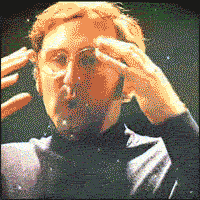

# Try out some examples!

In [14]:
from transformers import pipeline
import torch

# get current device with pytorch
device = torch.cuda.current_device()

# create pipeline for sentiment classifier with custom model and tokenizer
sentiment_classifier = pipeline(task='sentiment-analysis', model=model, tokenizer=tokenizer, device=device)

In [15]:
# let's see how our model classifies a good review
# this is from 'justinvitelli' (https://www.imdb.com/review/rw8972952)

review = """
First off this movie is for kids and fans of Nintendo and the Mario franchise.
I still think an adult who isnt a fan could still enjoy it but this movie is so 
full of fan service that it will have you smiling the whole time.
The voice acting I was skeptical but they all work and work well too.
Jack Black is the star here. I love how they kept the story simple like all of the games.
Truly felt like a video game on screen.
This movie felt like a beautifully animated amusement park ride.
The audio in the movie was amazing too.
The sounds and the score with reimagined iconic music was perfect.
Some of the songs in the movie felt unnecessary but they worked.
I think they should've bumped the run time to 105-120 min.
90 min felt too short as it goes by quick.
I havent had this much wholesome fun at the movies in a long time. 
If youre a fan you HAVE to see it.
"""
sentiment_classifier(review)

[{'label': 'POSITIVE', 'score': 0.9936867356300354}]

That is **99% POSITIVE**! *justinvitelli* loves the movie!

In [16]:
# let's see how our model classifies a bad review
# this is from 'industriousbug16' (https://www.imdb.com/review/rw8998214)

review = """
Flat, visual noise.
Fundamentally incurious. Potentially injurious.
The mystique generated by the characters in the games is here raked over and presented
haphazardly by hacks.
A hobbled attempt to explain a long and random evolution of characters who were never meant
to be narratised fails.
Doing it well is near impossible when you insist on EVERY LITTLE BIT OF LORE, 
from the last forty years being shoehorned into 90 minutes.
Makes little sense, shamelessly leans on member berries to stimulate older viewers but offers 
nothing else.
I feel sad for the animators who did a sterling job, but to no end as this movie has no soul.
"""
sentiment_classifier(review)

[{'label': 'NEGATIVE', 'score': 0.9941820502281189}]

That is **99% NEGATIVE**! *industriousbug16* must hate the movie very badly.

# Resources

### If you would like to use this model without running the entire notebook, try the model at my [HuggingFace](https://huggingface.co/wesleyacheng/movie-review-sentiment-classifier-with-bert).

### If you woud like to get this in GitHub, here's my [repo](https://github.com/wesleyacheng/movie-review-sentiment-classifier-with-bert).